> May 03, 2024 | {sub-ref}`wordcount-minutes` min read




Consulta la notación que se ha utilizado durante todo el documento en el siguiente [enlace](#3notacion).

# 3. Variational Quantum Classifier (VQC)

Existen múltiples métodos para clasificar un conjunto de datos utilizando un ordenador cuántico. Uno de ellos es el algoritmo conocido como **Variational Quantum Classifier** o **VQC**, que pertenece a la categoría de algoritmos cuánticos variacionales (VQA).

El VQC es un algoritmo de aprendizaje supervisado que hace uso de un circuito cuántico variacional. Este circuito, también llamado circuito cuántico parametrizado, tiene una estructura similar a la de una red neuronal clásica. Siguiendo con esta analogía, cada puerta cuántica parametrizada equivale a un nodo en una red clásica, y los parámetros que gobiernan estas puertas a los pesos en una red.

Al igual que el aprendizaje automático clásico, el algoritmo VQC tiene una fase de entrenamiento, en la que se proporcionan datos etiquetados, y una fase de validación, en la que se clasifican nuevos datos con el modelo ya entrenado para así evaluar la calidad del modelo. Se trata de un algoritmo de clasificación híbrido, ya que combina una componente cuántica y una componente clásica, tal y como se aprecia en la {numref}`fig_etapasQML`, que realiza un bucle de optimización de los parámetros clásicos del circuito cuántico.


::::{figure} imagenes/VQCfases.png
:name: fig_etapasQML
:width: 400px
:align: center
Etapas del algoritmo QML {cite}`bib_image1`
::::


<a id='VariationalQuantumCirc'></a>
## 3.1. Variational Quantum Circuit

Los circuitos cuánticos variacionales o parametrizados son circuitos que dependen de parámetros configurables y que se optimizan mediante un coprocesador clásico para realizar una tarea determinada.

En general, todo circuito variacional se divide en tres pasos:

1. **Preparación de datos (*State Preparation*)**: El primer paso en cualquier proceso de aprendizaje automático cuántico es trasladar los datos de tu problema clásico a estados cuánticos dentro de tu espacio de Hilbert. Al hacer este proceso, es importante tener en cuenta que para clasificar correctamente los datos, debemos introducir no linealidad en el proceso, ya que el circuito cuántico es lineal en el espacio de Hilbert. Esta no linealidad se puede introducir de diferentes formas, una de ellas es mediante un preprocesamiento clásico de los datos o mediante las puertas cuánticas que transformarán estos datos clásicos en características cuánticas de nuestro estado. Este proceso se conoce como codificación de caracteristicas o *feature encoding*; es el encargado de traducir nuestro problema clásico a un problema que nuestro circuito cuántico pueda tratar. A este paso también se le conoce como *quantum embedding* o *data encoding*. Para obtener más información sobre estas técnicas, puede consultar el siguiente {ref}`sec_QML_FeatureEncoding`.

2. **Circuito parametrizado**: El circuito diseñado para realizar una tarea concreta y está caracterizado por un operador unitario parametrizado $U(\mathbf{x}, \theta)$, $\mathbf{x}$ es la entrada del circuito (los datos codificados anteriormente) y $\theta$ son los parámetros variacionales. Este operador unitario está compuesto por diferentes capas de puertas cuánticas, la arquitectura para definir una capa puede cambiar según el problema y debe adaptarse para cada caso. También existen variantes más sofisticadas del VQC que combinan la arquitectura de capas con el mapeado de características, las cuales se discutirán más adelante.

3. **Medida/Optimización**: En esta etapa, se ejecuta el circuito y se mide repetidamente para obtener el valor esperado de un observable. Con este valor esperado, se intenta inferir la etiqueta que correspondía al dato codificado. A partir de esta medida, se calcula una función de coste y sus gradientes para poder optimizar los parámetros que caracterizan el circuito y repetir el proceso. Con suficientes iteraciones y si el *landscape* de la función de coste es navegable, los pesos de las puertas estarán optimizados para clasificar el conjunto de datos con el que se haya entrenado {cite}`bib_cerezo`.



<a id='Ejemplo'></a>
## 3.2. Data reuploading classifier

La técnica de *data reuploading* en clasificación con circuitos cuánticos fue introducida en {cite}`bib_salinas2020` y tiene la ventaja de introducir no linealidad en el sistema de manera nativa. El algoritmo consiste en aplicar técnicas de *feature encoding* de manera iterativa al principio de cada capa. De esta manera, con un *feature encoding* sencillo y repitiendolo en cada *layer* se pueden resolver problemas de clasificación no lineales con muy pocas capas.

<a id='Ejemplo'></a>
## 3.3. Ejemplos de aplicación

<a id='Ejemplo'></a>
### 3.3.1 VQC

A continuación, se presenta un ejemplo básico que demuestra el uso de un clasificador cuántico variacional. Como conjunto de datos de ejemplo, utilizaremos "two moons" incluido en la librería scikit-learn. Este conjunto de datos no se puede clasificar de manera lineal y nos ayudará más adelante a observar cómo introducir diferentes fuentes de no linealidad en el circuito variacional.

Primero cargamos la librería y las herramientas necesarias.

In [1]:
import numpy as np
import qibo
from time import time
import matplotlib.pyplot as plt
from qibo import callbacks, gates, hamiltonians, models
from qibo.symbols import Y, Z, I
from sklearn.datasets import make_moons
from qibo.models import Circuit

#Se desactiva los mensajes de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

#Fijar el backend en el que se ejecutará el programa
qibo.set_backend("tensorflow")

[Qibo 0.1.12.dev0|INFO|2024-05-08 13:48:30]: Using tensorflow backend on /device:CPU:0


A continuación, observamos el set de datos.

In [4]:
# Algunos hiperparámetros del sistema
nclasses=2 # Número de classes
measured_qubits= int(np.ceil(np.log2(nclasses))) #Número de qubits a medir(depende del numero de classes)
nqubits=2 # Número de qubits
nlayers=4 # Número de capas
nshots=10000 # Número de runs del circuito

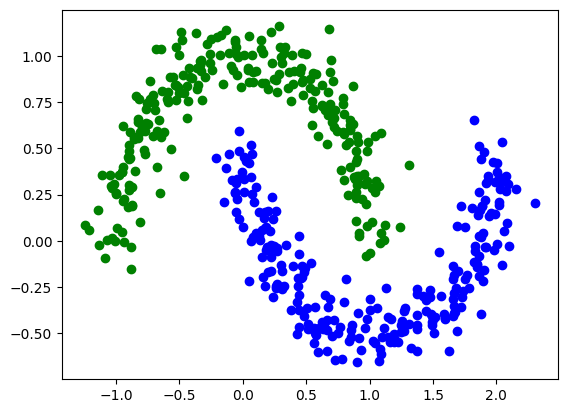

In [5]:
# Generamos el conjuto de datos con dos classes y lo mostramos en un gráfico
num_inputs = 2
num_samples = 500
X,y=make_moons(num_samples,noise=0.1)
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.show()

Vamos a empezar con un poco de preprocesamiento clásico. Observamos que los datos varían de -1 a 2. Teniendo en cuenta que más adelante los codificaremos en los ángulos de una rotación, vamos a reescalarlos para que estén en el rango de -1 a 1 y los vamos a centrar.

In [6]:
def procesdata(data):
    data=np.array(data) #Pasamos los datos a una array
    Min=data.min(axis=0)
    Max=data.max(axis=0)
    data=(2*data-Max-Min)*np.pi/(Max-Min) #Centramos y acotamos entre -1 y 1
    return data

Ahora vemos como este preprocesamiento a modificado nuestros datos

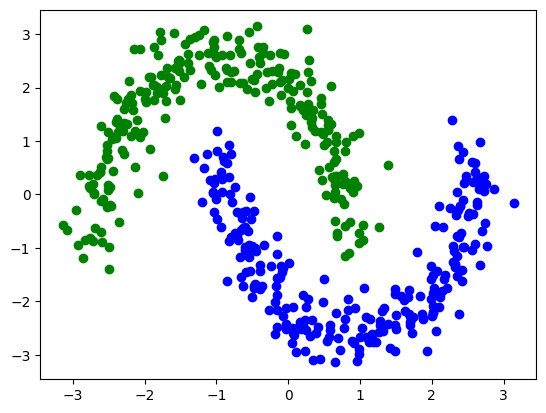

In [7]:
X_pad=procesdata(X)
Y = 2*y -np.ones(len(y)) #Cambaimos las etiquetas de cada datos de 0,1 a -1,1
for x, y_target in zip(X_pad, y): 
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.show()

Separamos el set de entrenamiento del de validación

In [8]:
num_train = int(0.80 * len(Y))
index = np.random.permutation(range(len(Y)))
Y_train = Y[index[:num_train]]
Y_val = Y[index[num_train:]]
X_train = X_pad[index[:num_train]]
X_val = X_pad[index[num_train:]]

Definimos el ansatz de las capas del VQC que utilizaremos para construir el circuito. Como *feature encoding* utilizaremos el dense angle en dos qubits por lo que duplicaremos el *feature encoding*. De esta manera conseguimos de eficiente una buena no lienalidad.

In [9]:
def create_circuit(w,x, nqubits= 2,nlayers=nlayers):
    """
    Args:
        x: input del circuito
        w: parámetros del circuito
        nqubits: número de qubits
        nlayers: número de capas
    Returns:
        instancia de circuito cuántico para ejecutar
    """
    
    c= Circuit(nqubits=nqubits)

    c.add(gates.RY(q=0, theta = w[0]*x[0]))
    c.add(gates.RY(q=1, theta = w[1]*x[0]))
    
    c.add(gates.RZ(q=0, theta = w[2]*x[1]))
    c.add(gates.RZ(q=1, theta = w[3]*x[1]))
    
    for i in range(nlayers):
        j=i*4+3
        #j=7+i*4
        c.add(gates.RY(q=0, theta = w[j+1]))
        c.add(gates.RY(q=1, theta = w[j+2]))
     
        c.add(gates.CZ(0,1))
    
        c.add(gates.RY(q=0, theta = w[j+3]))
        c.add(gates.RY(q=1, theta = w[j+4]))
    
    # Última rotación
    c.add(gates.RY(q=0, theta = w[j+5]))
    c.add(gates.RY(q=1, theta = w[j+6]))
    
    c.add(gates.M(0))
    
    return c

Ahora definimos las funciones que vamos a necesitar durante el entrenamiento. La función  "Predictions" computa los valores esperados de cada observable para cada dato que se ha dado de input al circuito.

In [10]:
#Definimos el observable que vamos a medir en este caso pauliz en el primer qubit
def hamiltonian(nqubits):
    if nqubits==1:
        Obj=Z(0)
    else:
        Obj = np.kron( Z(0), I(1))
    h = hamiltonians.SymbolicHamiltonian(Obj)
    return h

In [21]:
def Predictions(data, theta, nqubits, nshots=10000,R=False):
    """
    Args:
        data: input del circuito
        theta: parámetros del circuito
        nqubits: número de qubits
        nshots: número de shots 
        R= parámetro que controla si hacemos data reuploading
    Returns:
        numpy.array() con los valores esperados correspondientes al input
    """
    if R==True:
        c= create_circuitd(theta,data,nqubits)
        
    else:
        c =  create_circuit(theta,data, nqubits)
    h = hamiltonian(nqubits)
    expected_value = h.expectation(c.execute().state())
    return expected_value


Como función de coste utilizamos el *square loss* defindo tal que:
$$
\mathit{\text{Square loss}} = \frac {\sum_{i=1}^N (y_i - \tilde{y_i})^2}{N}
$$
Utilizaremos también el accuracy o porcentaje de acierto para medir el rendimiento del modelo. Hay que tener en cuenta que los valores que tendremos como salida de "Predictions" serán los valores esperados de un observable. Por consiguiente si queremos asignar una clase a cada valor podemos hacerlos dependiendo del signo, ya que el valor esperado está entre -1 y 1.

In [12]:
def sqloss_acc(labels, predictions):
    sqloss = 0
    acc = 0
    for label, prediction in zip(labels, predictions):    
        sqloss = sqloss + (label - prediction)**2
        if np.sign(label)==np.sign(prediction):
            acc += 1
    sqloss = sqloss / len(labels)
    acc = acc / len(labels)
    print('Loss: ', sqloss.numpy(), 'Acc: ', acc)
    return sqloss, acc

In [13]:
def Cost_function(theta, data, Y, nqubits, nshots=10000,R=False):

    predictions = [Predictions(x, theta,nqubits,nshots,R) for x in data]

    return sqloss_acc(Y, predictions)[0]


Iniciamos los parámetros del sistema aleatoriamente

In [14]:
#Inicializamos aleatoriamente los parametros
np.random.seed(0)
test_params = (np.pi* np.random.rand(2 * nqubits * nlayers + nqubits + 4))

#imprimimos los parametros
print('número de parámetros a ajustar:',len(test_params))
print('Parametros iniciales',test_params)

#pasamos los parametros a un tensor y comprovamos la fucnión de coste
params = tf.Variable(test_params,dtype=tf.complex128)
cost_all = Cost_function(params, X_pad, Y,nqubits)
#print('params',params)
print('cost_all',cost_all)

número de parámetros a ajustar: 22
Parametros iniciales [1.72414847 2.24683366 1.89363699 1.711801   1.33095081 2.0291362
 1.37472077 2.80158751 3.02743585 1.20461706 2.48727756 1.66157239
 1.78456462 2.9078476  0.22316636 0.27372477 0.06351797 2.61575239
 2.44465153 2.73322377 3.07442019 2.51063067]
Loss:  1.2629404603236218 Acc:  0.526
cost_all tf.Tensor(1.2629404603236218, shape=(), dtype=float64)


Entrenamos el modelo e imprimimos el porcentaje de acierto.

```{code-block} python
#Contamos el timepo que tarda
start_time = time()


#Hiperparametros del optmizador
n_iter = 60
learning_rate = 0.015
#momentum = 100
#batch_size = 5


for it in range(n_iter):  # Número máximo de iteraciones que hará el algoritmo.
    print('\nIteración',it)
    
    # Calcular el gradiente:
    with tf.GradientTape() as tape:
        value_cost= Cost_function(params, X_train, Y_train, nqubits)
    tf_grads = tf.math.real(tape.gradient(value_cost, [params]))
    
    # Actualizar los parámetros:
    optimizer = getattr(tf.optimizers, "Adam")(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,epsilon=1e-08)
    optimizer.apply_gradients(zip(tf_grads, [params]))
    
        
# Calcular coste con todos los datos y mirar precisión para criterio de parada.
cost_val = Cost_function(params, X_val, Y_val,nqubits)
cost_all = Cost_function(params, X_pad, Y,nqubits)
        
tiempo_ej = time()-start_time
print('El tiempo que se ha tardado en ejecutar el algoritmo ha sido: ',tiempo_ej/60, 'minutos')
```


Ahora podemos hacer un gráfico para ver como clasifica el circuito.

In [15]:
params=tf.Variable(np.array([ 1.15410294+0.j,  2.87684302+0.j,  2.6736488 +0.j,  0.84173673+0.j,
        1.15082887+0.j,  1.81912963+0.j,  1.40472511+0.j,  2.59156761+0.j,
        3.05744019+0.j,  0.99459716+0.j,  2.72729385+0.j,  1.90203343+0.j,
        2.02458091+0.j,  3.14830863+0.j, -0.0168414 +0.j,  0.48372381+0.j,
       -0.17648978+0.j,  2.82575143+0.j,  2.26463316+0.j,  2.73322377+0.j,
        2.89440183+0.j,  2.51063067+0.j]),dtype=tf.complex128)
params

<tf.Variable 'Variable:0' shape=(22,) dtype=complex128, numpy=
array([ 1.15410294+0.j,  2.87684302+0.j,  2.6736488 +0.j,  0.84173673+0.j,
        1.15082887+0.j,  1.81912963+0.j,  1.40472511+0.j,  2.59156761+0.j,
        3.05744019+0.j,  0.99459716+0.j,  2.72729385+0.j,  1.90203343+0.j,
        2.02458091+0.j,  3.14830863+0.j, -0.0168414 +0.j,  0.48372381+0.j,
       -0.17648978+0.j,  2.82575143+0.j,  2.26463316+0.j,  2.73322377+0.j,
        2.89440183+0.j,  2.51063067+0.j])>

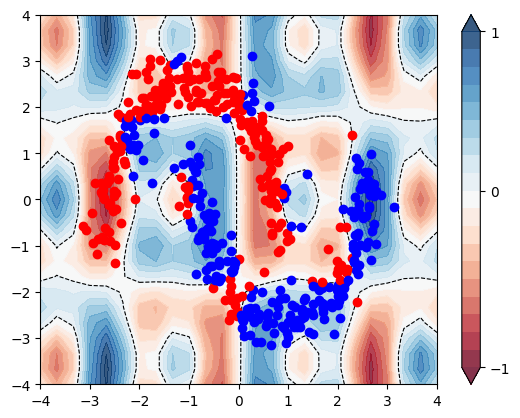

In [16]:
plt.figure()
cm = plt.cm.RdBu


xx, yy = np.meshgrid(np.linspace(-4, 4, 25), np.linspace(-4, 4, 25))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

#X_grid=procesdata(X_grid)

predictions_grid = [ Predictions(f, params, nqubits, nshots=nshots ) for f in X_grid]
Z1 = np.reshape(predictions_grid, xx.shape)


cnt = plt.contourf(
    xx, yy, Z1, levels=np.arange(-1, 1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z1, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

y2=[np.sign(Predictions(
            ket,
            params,
            nqubits,
            nshots=nshots,
            
        )) for ket in X_pad]
for x, y_target in zip(X_pad, y2):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "ro")
plt.show()

<a id='Ejemplo'></a>
### 3.3.2 Data re-uploading

En esta sección enseñaremos como funciona el algoritmo de data re-uploading para clasificar utilizando solo un qubit. Utilizaremos los mismos datos y el mismo preprocesamiento. Debemos modificar el circuito para implementar el algoritmo.

In [17]:
def create_circuitd(w,x, nqubits= 2,nlayers=nlayers):
    
    c= Circuit(nqubits=nqubits)
    for i in range(nlayers):
        c.add(gates.RY(q=0, theta = x[0]+w[2*i]))
        c.add(gates.RZ(q=0, theta = x[1]+w[2*i+1]))
    
    c.add(gates.M(0))
    
    return c

In [18]:
nclasses=2
measured_qubits= int(np.ceil(np.log2(nclasses)))
nqubits=1
nlayers=3
nshots=10000

In [19]:
num_data = len(Y)
num_train = int(0.80 * num_data)
index = np.random.permutation(range(num_data))
X_pad2=X_pad
Y_train = Y[index[:num_train]]
Y_val = Y[index[num_train:]]
X_train2 = X_pad2[index[:num_train]]
X_val = X_pad2[index[num_train:]]

In [22]:
#Inicializamos la variable
np.random.seed(0)
test_params = np.random.normal(0,1,8)*np.pi

print('número de parámetros a ajustar:',len(test_params))
print('test_params_INI',test_params)

#Pasamos la variable a un tensor
params = tf.Variable(test_params,dtype=tf.complex128)  
cost_all = Cost_function(params, X_pad2, Y,nqubits,R=True)

print('params',params)
print('cost_all',cost_all)

número de parámetros a ajustar: 8
test_params_INI [ 5.54193389  1.25713095  3.07479606  7.03997361  5.86710646 -3.07020901
  2.98479079 -0.47550269]
Loss:  1.985096113316032 Acc:  0.306
params <tf.Variable 'Variable:0' shape=(8,) dtype=complex128, numpy=
array([ 5.54193389+0.j,  1.25713095+0.j,  3.07479606+0.j,  7.03997361+0.j,
        5.86710646+0.j, -3.07020901+0.j,  2.98479079+0.j, -0.47550269+0.j])>
cost_all tf.Tensor(1.985096113316032, shape=(), dtype=float64)


```{code-block} python

start_time = time()

#Hiperparametros del optimizador
n_iter = 20
learning_rate = 0.09
momentum = 4
batch_size = 5

for it in range(n_iter):  # Emepzamos a iterar el algoritmo
    print('\nIteración',it)
    
    # Calcular el gradiente:
    with tf.GradientTape() as tape:
        value_cost= Cost_function(params, X_train2, Y_train, nqubits,R=True) 
    tf_grads =tf.math.real( tape.gradient(value_cost, [params]))

    # Actualizar los parámetros:
    optimizer = getattr(tf.optimizers, "Adam")(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,epsilon=1e-08)
    optimizer.apply_gradients(zip(tf_grads, [params]))

#Calculamos el coste final
cost_val = Cost_function(params, X_val, Y_val,nqubits,R=True)
cost_all = Cost_function(params, X_pad2, Y,nqubits,R=True)
        
tiempo_ej = time()-start_time
print('El tiempo que se ha tardado en ejecutar el algoritmo ha sido: ',tiempo_ej/60, 'minutos')
```


Hacemos un gráfico para demostrar como el circuito clasifica.

In [24]:
paramsd=tf.Variable(np.array([ 6.98192218+0.j, -0.5428519 +0.j,  3.79479336+0.j,  8.11996204+0.j,
        5.50711014+0.j, -2.34991814+0.j,  2.44480601+0.j, -0.47550269+0.j]),dtype=tf.complex128)
paramsd

<tf.Variable 'Variable:0' shape=(8,) dtype=complex128, numpy=
array([ 6.98192218+0.j, -0.5428519 +0.j,  3.79479336+0.j,  8.11996204+0.j,
        5.50711014+0.j, -2.34991814+0.j,  2.44480601+0.j, -0.47550269+0.j])>

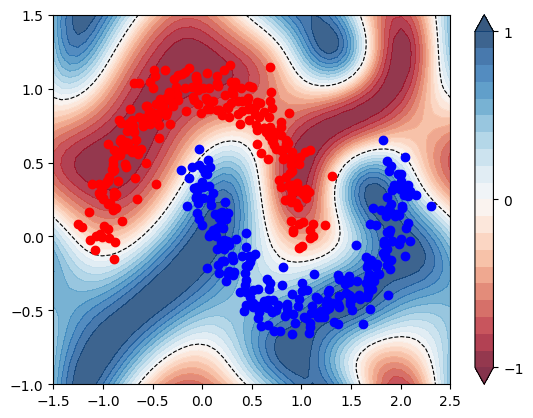

In [25]:
plt.figure()
cm = plt.cm.RdBu
paramsd=params

xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 50), np.linspace(-1, 1.5, 50))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

X_grid=procesdata(X_grid)

predictions_grid = [
            Predictions(
            f,
            paramsd,
            nqubits,
            nshots=nshots,
            R=True
        ) for f in X_grid]
Z2 = np.reshape(predictions_grid, xx.shape)


cnt = plt.contourf(
    xx, yy, Z2, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z2, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

y2=[Predictions(
            ket,
            paramsd,
            nqubits,
            nshots=nshots,
            R=True
        )
        for ket in X_pad2
    ]
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "ro")
plt.show()

<a id='3notacion'></a>
::::::{admonition} ANEXO NOTACIÓN
:class: note


Para que la comprensión de los notebooks sea mejor se ha unificado la notación utilizada en los mismos. Para diferenciar un vector de un valor único se hará uso de la negrita. De manera que $\mathbf{x}$ corresponde a un vector y $z$ será una variable de una única componente. 

    
Si se quiere hacer referencia a dos vectores distintos pero que pertenecen al mismo *dataset* se utilizará un subíndice, es decir, $\mathbf{x_i}$ hará referencia al i-ésimo vector del dataset. Si se quiere referenciar una característica concreta del vector $\mathbf{x_i}$ se añadirá un nuevo subíndice, de manera que $\mathbf{x_{i_j}}$ hará referencia a la j-ésima variable del i-ésimo vector.

::::::


---
Autores:

Carmen Calvo ([SCAYLE](https://www.scayle.es/)), Antoni Alou ([PIC](https://www.pic.es/)), Carlos Hernani ([UV](https://www.uv.es/)), Nahia Iriarte ([NASERTIC](https://www.nasertic.es/es)) y Carlos Luque ([IAC](https://www.iac.es/))

<img src="images/LOGO-SCAILE.png"  width="140px">
<img src="images/Logo_pic.png" width="140px">
<img src="images/Logo_UV.jpg" width="160px">
<img src="images/Logo_Nasertic.png" width="160px">
<img src="images/Logo_IAC.jpg" width="160px">

---
::::{figure} https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png
:width: 2000px
:align: center
::::

<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<center>
<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />
</center>